Making the outputs in the format required defined by Adina. This incorporates lessons learned from No Air and some of the formatting in the notebook produced by Lili et al.

In [78]:
pwd

'/Users/james/JWSTdata/W39_MIRI/MAST_2023-02-15T0420/JWST/reduction06/reduction_notebooks'

In [79]:
%matplotlib nbagg
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from glob import glob
from fitting_utils import plotting_utils as pu
import xarray as xr
import json #we will use this to dump model parameters into an attribute

In [80]:
def load_model_arrays(path,time_input,original_nbins,WL_fit):
    
    if original_nbins > 1:
        _,_,_,_,_,_,_,_,success,_ = pu.load_completed_bins(path)
        fail = np.array(sorted(set(np.arange(1,original_nbins+1)).difference(success)))
        print("Fits failed for bins",fail)
        
    time_rounded = np.round(time_input,6).tolist()
    fluxarr = np.zeros((original_nbins, len(time_input)))
    fluxerrarr = np.zeros((original_nbins, len(time_input)))
    modelarr = np.zeros((original_nbins, len(time_input)))
    residualarr = np.zeros((original_nbins, len(time_input)))
    
    for i,f in enumerate(range(1,original_nbins+1)):
        
        print("Reading in bin %d"%(i+1))
        
        if original_nbins > 1:
            if f not in success:
                print("%s not found, skipping"%f)
                continue
        
        if WL_fit:
            file = path + "model_tab_WL.dat"
        else:
            file = path + "model_tab_wb%s.dat"%(str(f).zfill(4))
            
        time_in,flux_in,flux_err_in,model_in,residual_in = np.loadtxt(file,usecols=[0,1,3,4,7],unpack=True)
        index_to_be_selected = np.array([time_rounded.index(j) for j in time_in])
        fluxarr[i,index_to_be_selected] = flux_in
        fluxerrarr[i,index_to_be_selected] = flux_err_in
        modelarr[i,index_to_be_selected] = model_in
        residualarr[i,index_to_be_selected] = residual_in
        
    return fluxarr,fluxerrarr,modelarr,residualarr



def plot_2d_arrays(flux_array,model_array,residual_array):

    # Set up the figure and subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

    # Plot the data for each subplot using imshow
    ax1.imshow(flux_array, aspect = 'auto', vmin = 0.99, vmax = 1.01, cmap='gray')
    ax2.imshow(model_array, aspect = 'auto', vmin = 0.99, vmax = 1.01, cmap='gray')
    ax3.imshow(residual_array, aspect = 'auto',cmap='gray') # vmin = 0.99, vmax = 1.0, 
    
    ax1.set_title("Flux")
    ax2.set_title("Model")
    ax3.set_title("Residual")

    ax2.set_xlabel("Time (days)")
    ax1.set_ylabel("Pixel row")
    return
    

In [81]:
# time arrays
time_array = pickle.load(open("../pickled_objects_300_cut/BJD_TDB_time.pickle","rb"))

# stellar flux array
flux = pickle.load(open("../pickled_objects_300_cut/star1_flux_resampled.pickle","rb"))

# stellar error array
flux_error = pickle.load(open("../pickled_objects_300_cut/star1_error_resampled.pickle","rb"))

# wavelength array
wavelength = pickle.load(open("../pickled_objects/wvl_solution_miri.pickle","rb"))

# wvl bin centres
wb_centres = pickle.load(open("../pickled_objects/wb/Adina_pixel_bins/wb_bin_centres.pickle","rb"))

# wb half widths
wb_half_widths = pickle.load(open("../pickled_objects/wb/Adina_pixel_bins/wb_full_widths.pickle","rb"))/2

# transmission spectrum
trans_spec = np.loadtxt("../fitting/wb_300_clipped/time2_fixed_ld_CMC_from_WL-fixed-LD_correct_t0/transmission_spectrum_depths.dat")

# white light model tables
WL_flux,WL_flux_err,WL_models,WL_residuals = load_model_arrays("../fitting/WL_300_clipped/time2_fixed_LD/",\
                                                               time_array,1,WL_fit=True)

# wavelength bin model tables
wb_flux,wb_flux_err,wb_models,wb_residuals = load_model_arrays("../fitting/wb_300_clipped/time2_fixed_ld_CMC_from_WL-fixed-LD_correct_t0/",\
                                                               time_array,51,WL_fit=False)

print(time_array.shape,flux.shape,flux_error.shape,wavelength.shape)

time_array += 240000.5 # converting from MJD to BJD

Reading in bin 1
Fits failed for bins []
Reading in bin 1
Reading in bin 2
Reading in bin 3
Reading in bin 4
Reading in bin 5
Reading in bin 6
Reading in bin 7
Reading in bin 8
Reading in bin 9
Reading in bin 10
Reading in bin 11
Reading in bin 12
Reading in bin 13
Reading in bin 14
Reading in bin 15
Reading in bin 16
Reading in bin 17
Reading in bin 18
Reading in bin 19
Reading in bin 20
Reading in bin 21
Reading in bin 22
Reading in bin 23
Reading in bin 24
Reading in bin 25
Reading in bin 26
Reading in bin 27
Reading in bin 28
Reading in bin 29
Reading in bin 30
Reading in bin 31
Reading in bin 32
Reading in bin 33
Reading in bin 34
Reading in bin 35
Reading in bin 36
Reading in bin 37
Reading in bin 38
Reading in bin 39
Reading in bin 40
Reading in bin 41
Reading in bin 42
Reading in bin 43
Reading in bin 44
Reading in bin 45
Reading in bin 46
Reading in bin 47
Reading in bin 48
Reading in bin 49
Reading in bin 50
Reading in bin 51
(1479,) (1479, 224) (1479, 224) (224,)


### Making the xarrays

In [82]:
s3 = xr.Dataset(
    data_vars=dict(
        stellar_flux=(["central_wavelength","flux"],
                       flux,{'units': 'DN/S'}),#, required
        stellar_flux_error=(["central_wavelength","flux_error"],
                       flux_error,{'units': 'DN/S'}),#, required
    ),
    coords=dict(
        wavelength=(["wavelength"], 
                             wavelength,{'units': 'micron'}),#required*
    ),
    attrs=dict(author="J Kirk",#required
               contact="j.kirk22@imperial.ac.uk",#required,
               code="Tiberius",#could also insert github link
              )
)

In [83]:
s3

<xarray.Dataset>
Dimensions:             (central_wavelength: 1479, flux: 224, flux_error: 224, wavelength: 224)
Coordinates:
  * wavelength          (wavelength) float32 11.49 11.47 11.46 ... 4.392 4.177
Dimensions without coordinates: central_wavelength, flux, flux_error
Data variables:
    stellar_flux        (central_wavelength, flux) float64 44.05 ... 2.054e+03
    stellar_flux_error  (central_wavelength, flux_error) float64 4.756 ... 15.18
Attributes:
    author:   J Kirk
    contact:  j.kirk22@imperial.ac.uk
    code:     Tiberius

<IPython.core.display.Javascript object>


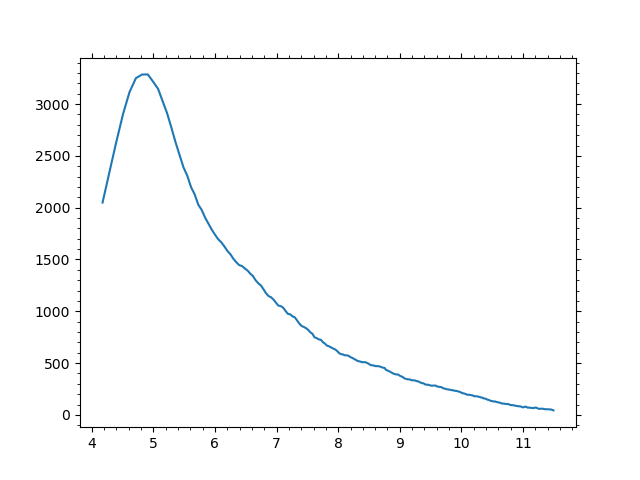

In [84]:
plt.figure()
plt.plot(s3["wavelength"],s3["stellar_flux"][10])
plt.show()

In [85]:
s4 = xr.Dataset(
    data_vars=dict(
        WL_flux=(["flux"],
                       WL_flux[0],{'units': 'unitless'}),#, required
        WL_flux_error=(["flux_error"],
                       WL_flux_err[0],{'units': 'unitless'}),
        WL_residuals=(["residuals"],
                       WL_residuals[0],{'units': 'unitless'}),
        WL_residuals_error=(["residuals_error"],
                       WL_flux_err[0],{'units': 'unitless'}),
        WL_best_fit_model=(["best_fit_model"],
                       WL_models[0],{'units': 'unitless'}),
    ),
    coords=dict(
        time=(["time"],time_array,{'units': 'BJD'}),#required*
    ),
    attrs=dict(author="J Kirk",#required
               contact="j.kirk22@imperial.ac.uk",#required,
               code="Tiberius",#could also insert github link
              )
)

In [86]:
s4

<xarray.Dataset>
Dimensions:             (flux: 1479, flux_error: 1479, residuals: 1479, residuals_error: 1479, best_fit_model: 1479, time: 1479)
Coordinates:
  * time                (time) float64 3e+05 3e+05 3e+05 ... 3e+05 3e+05 3e+05
Dimensions without coordinates: flux, flux_error, residuals, residuals_error, best_fit_model
Data variables:
    WL_flux             (flux) float64 1.001 1.001 1.001 ... 0.9998 0.9991 0.999
    WL_flux_error       (flux_error) float64 0.000514 0.000514 ... 0.000513
    WL_residuals        (residuals) float64 2.8e-05 0.000311 ... -0.001171
    WL_residuals_error  (residuals_error) float64 0.000514 0.000514 ... 0.000513
    WL_best_fit_model   (best_fit_model) float64 1.001 1.001 1.001 ... 1.0 1.0
Attributes:
    author:   J Kirk
    contact:  j.kirk22@imperial.ac.uk
    code:     Tiberius

<IPython.core.display.Javascript object>


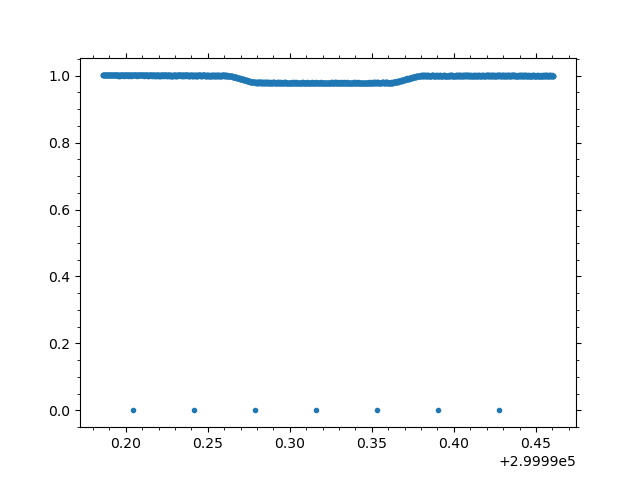

In [87]:
plt.figure()
plt.errorbar(s4["time"],s4["WL_flux"],yerr=s4["WL_flux_error"],fmt=".")
plt.show()

In [88]:
s5 = xr.Dataset(
    data_vars=dict(
        wb_flux=(["central_wavelength","time"],
                       wb_flux,{'units': 'unitless'}),#, required
        wb_flux_error=(["central_wavelength","time"],
                       wb_flux_err,{'units': 'unitless'}),
        wb_residuals=(["central_wavelength","time"],
                       wb_residuals,{'units': 'unitless'}),
        wb_residuals_error=(["central_wavelength","time"],
                       wb_flux_err,{'units': 'unitless'}),
        wb_best_fit_model=(["central_wavelength","time"],
                       wb_models,{'units': 'unitless'}),
    ),
    coords=dict(
        central_wavelength=(["central_wavelength"], 
                             wb_centres,{'units': 'micron'}),#required*
        time=(["time"], 
                             time_array,{'units': 'BJD'}),#required*
        bin_half_width=(["bin_half_width"], 
                             wb_half_widths,{'units': 'micron'})
        
    ),
    attrs=dict(author="J Kirk",#required
               contact="j.kirk22@imperial.ac.uk",#required,
               code="Tiberius",#could also insert github link
              )
)

<IPython.core.display.Javascript object>


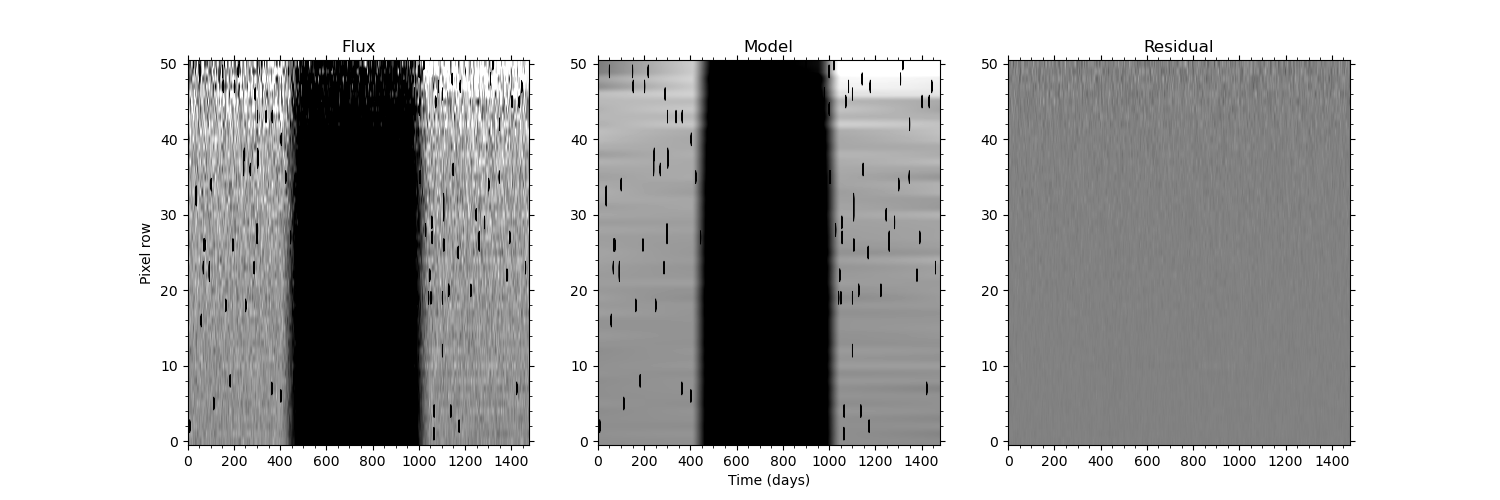

In [89]:
plot_2d_arrays(s5["wb_flux"],s5["wb_best_fit_model"],s5["wb_residuals"])

In [90]:
s5["wb_flux"]

<xarray.DataArray 'wb_flux' (central_wavelength: 51, time: 1479)>
array([[0.999972, 0.99948 , 1.004497, ..., 1.000795, 1.001181, 1.002696],
       [0.999035, 0.999812, 1.000093, ..., 0.998928, 0.999995, 0.999624],
       [1.001462, 1.000384, 1.000905, ..., 0.99979 , 0.997964, 1.002725],
       ...,
       [0.989504, 1.035491, 0.998861, ..., 1.000454, 0.998549, 0.991853],
       [0.995788, 1.002403, 0.994263, ..., 1.013802, 1.010415, 1.012036],
       [0.983773, 1.003978, 1.007594, ..., 1.003928, 1.031198, 0.989138]])
Coordinates:
  * central_wavelength  (central_wavelength) float64 5.125 5.25 ... 11.25 11.38
  * time                (time) float64 3e+05 3e+05 3e+05 ... 3e+05 3e+05 3e+05
Attributes:
    units:    unitless

In [91]:
s6 = xr.Dataset(
    data_vars=dict(
        wavelength=(["central_wavelength"],
                       trans_spec[:,0],{'units': 'micron'}),#, required
        wavelength_error=(["central_wavelength"],
                       trans_spec[:,1]/2,{'units': 'micron'}),
        dppm=(["transit_depth"],
                       1e6*trans_spec[:,2],{'units': 'ppm'}),
        dppm_error=(["transit_depth_error"],
                       1e6*trans_spec[:,3],{'units': 'ppm'}),
    ),
    coords=dict(
        central_wavelength=(["central_wavelength"], 
                             trans_spec[:,0],{'units': 'micron'}),#required*
        bin_half_width=(["bin_half_width"], 
                             trans_spec[:,1]/2,{'units': 'micron'})
        
    ),
    attrs=dict(author="J Kirk",#required
               contact="j.kirk22@imperial.ac.uk",#required,
               code="Tiberius",#could also insert github link
              )
)

In [92]:
s6

<xarray.Dataset>
Dimensions:             (central_wavelength: 51, transit_depth: 51, transit_depth_error: 51, bin_half_width: 51)
Coordinates:
  * central_wavelength  (central_wavelength) float64 5.125 5.25 ... 11.25 11.38
  * bin_half_width      (bin_half_width) float64 0.0625 0.0625 ... 0.0625 0.0625
Dimensions without coordinates: transit_depth, transit_depth_error
Data variables:
    wavelength          (central_wavelength) float64 5.125 5.25 ... 11.25 11.38
    wavelength_error    (central_wavelength) float64 0.0625 0.0625 ... 0.0625
    dppm                (transit_depth) float64 2.086e+04 ... 1.944e+04
    dppm_error          (transit_depth_error) float64 151.0 151.0 ... 1.507e+03
Attributes:
    author:   J Kirk
    contact:  j.kirk22@imperial.ac.uk
    code:     Tiberius

<IPython.core.display.Javascript object>


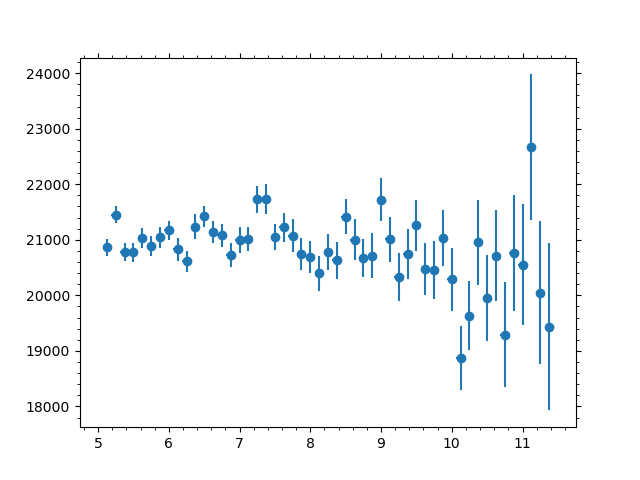

In [93]:
plt.figure()
plt.errorbar(s6["wavelength"],s6["dppm"],yerr=s6["dppm_error"],xerr=s6["wavelength_error"],fmt="o")
plt.show()

In [94]:
import os
try:
    os.mkdir("../data_products")
except:
    pass


In [97]:
s3.to_netcdf("../data_products/TEAM01-stellar-spectra.h5",engine="h5netcdf")
s4.to_netcdf("../data_products/TEAM01-white-light-curve.h5",engine="h5netcdf")
s5.to_netcdf("../data_products/TEAM01-spectroscopic-light-curves.h5",engine="h5netcdf")
s6.to_netcdf("../data_products/TEAM01-wasp-39b-spectrum.h5",engine="h5netcdf")